In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, unix_timestamp, avg, min, max, median
from pyspark.sql.window import Window


In [3]:
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "10G") \
    .config("spark.executor.memory", "10G") \
    .config("spark.log.level", "ERROR").getOrCreate()

25/06/19 14:25:41 WARN Utils: Your hostname, dyscarnate-B550M-HDV-AR resolves to a loopback address: 127.0.1.1; using 192.168.0.105 instead (on interface enp4s0)
25/06/19 14:25:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/19 14:25:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting Spark log level to "ERROR".


In [4]:
data_path = "/samsung/data/transactions"
df = spark.read.parquet(data_path)

In [5]:
df.printSchema()  

root
 |-- block_number: long (nullable = true)
 |-- transaction_index: decimal(20,0) (nullable = true)
 |-- transaction_hash: binary (nullable = true)
 |-- nonce: decimal(20,0) (nullable = true)
 |-- from_address: binary (nullable = true)
 |-- to_address: binary (nullable = true)
 |-- value_binary: binary (nullable = true)
 |-- value_string: string (nullable = true)
 |-- value_f64: double (nullable = true)
 |-- input: binary (nullable = true)
 |-- gas_limit: decimal(20,0) (nullable = true)
 |-- gas_used: decimal(20,0) (nullable = true)
 |-- gas_price: decimal(20,0) (nullable = true)
 |-- transaction_type: long (nullable = true)
 |-- max_priority_fee_per_gas: decimal(20,0) (nullable = true)
 |-- max_fee_per_gas: decimal(20,0) (nullable = true)
 |-- success: boolean (nullable = true)
 |-- n_input_bytes: long (nullable = true)
 |-- n_input_zero_bytes: long (nullable = true)
 |-- n_input_nonzero_bytes: long (nullable = true)
 |-- chain_id: decimal(20,0) (nullable = true)



In [6]:
from pyspark.sql.functions import count
df.count()

13577002

In [7]:
#Преобразование данных
from pyspark.sql.functions import col, sha2, hex

df = df.withColumn("from_address", hex(col("from_address"))) \
       .withColumn("to_address", hex(col("to_address"))) \
       .withColumn("transaction_hash", hex(col("transaction_hash")))

In [8]:
#Число транзакций в блоке
df.groupBy("block_number") \
  .count() \
  .orderBy("count", ascending=False) \
  .limit(10) \
  .show(truncate=False)

+------------+-----+
|block_number|count|
+------------+-----+
|21289505    |1179 |
|21313704    |1089 |
|21268920    |1064 |
|21298241    |941  |
|21298407    |911  |
|21275775    |905  |
|21195831    |884  |
|21289528    |852  |
|21298229    |842  |
|21261819    |782  |
+------------+-----+



In [9]:
# Топ отправителей по объему (value_f64)
from pyspark.sql.functions import sum, avg, max, min

df.groupBy("from_address") \
  .agg(sum("value_f64").alias("total_sent"), 
       avg("value_f64").alias("avg_sent"),
       count("*").alias("transaction_count")) \
  .orderBy("transaction_count", ascending=False) \
  .limit(10) \
  .show(truncate=False)

[Stage 7:====================================================>    (24 + 2) / 26]

+----------------------------------------+---------------------+----------------------+-----------------+
|from_address                            |total_sent           |avg_sent              |transaction_count|
+----------------------------------------+---------------------+----------------------+-----------------+
|B5D85CBF7CB3EE0D56B3BB207D5FC4B82F43F511|1.1884602194080316E24|9.34257968703497E18   |127209           |
|46340B20830761EFD32832A74D7169B29FEB9758|1.3843707956797248E23|1.10871178465976691E18|124863           |
|F89D7B9C864F589BBF53A82105107622B35EAA40|3.035837175996922E23 |2.7497528857622205E18 |110404           |
|28C6C06298D514DB089934071355E5743BF21D60|2.1174667398334908E24|2.000516542744639E19  |105846           |
|DFD5293D8E347DFE59E90EFD55B2956A1343963D|3.141719632204998E23 |3.1700599683217951E18 |99106            |
|21A31EE1AFC51D94C2EFCCAA2092AD1028285549|3.433369601589801E23 |3.4944170677636316E18 |98253            |
|0D0707963952F2FBA59DD06F2B425ACE40B492FE|6.99

In [10]:
# Топ получателей
df.groupBy("to_address") \
  .agg(sum("value_f64").alias("total_received")) \
  .orderBy("total_received", ascending=False) \
  .limit(10) \
  .show(truncate=False)

[Stage 10:=================================================>      (23 + 3) / 26]

+----------------------------------------+---------------------+
|to_address                              |total_received       |
+----------------------------------------+---------------------+
|28C6C06298D514DB089934071355E5743BF21D60|2.211588073311635E24 |
|A9D1E08C7793AF67E9D92FE308D5697FB81D3E43|1.1973427220088355E24|
|B5D85CBF7CB3EE0D56B3BB207D5FC4B82F43F511|1.1521026947300787E24|
|EAE7380DD4CEF6FBD1144F49E4D1E6964258A4F4|4.2478679083094E23   |
|CD531AE9EFCCE479654C4926DEC5F6209531CA7B|4.072977473848594E23 |
|DFD5293D8E347DFE59E90EFD55B2956A1343963D|3.926530268196257E23 |
|DBF5E9C5206D0DB70A90108BF936DA60221DC080|3.8410999939865993E23|
|21A31EE1AFC51D94C2EFCCAA2092AD1028285549|3.754475770492716E23 |
|77134CBC06CB00B66F4C7E623D5FDBF6777635EC|3.6982387204511E23   |
|CEB69F6342ECE283B2F5C9088FF249B5D0AE66EA|3.684533194714802E23 |
+----------------------------------------+---------------------+



In [64]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, hex, when, countDistinct
# 1. Агрегация по адресам
address_features = df.groupBy("from_address").agg(
    F.count("*").alias("outgoing_tx_count"),
    F.mean("value_f64").alias("avg_outgoing_value"),
    F.sum(when(col("success") == False, 1).otherwise(0)).alias("failed_tx_count"),
    countDistinct("to_address").alias("unique_recipients"),
    F.sum("n_input_nonzero_bytes").alias("contract_interactions")
)


In [65]:
# 2. Временные признаки
window_spec = Window.partitionBy("from_address").orderBy("block_number")

time_features = df.withColumn("prev_block", F.lag("block_number").over(window_spec)) \
                 .withColumn("block_diff", col("block_number") - col("prev_block")) \
                 .groupBy("from_address").agg(
                     F.expr("percentile_approx(block_diff, 0.5)").alias("median_time_between_tx"),
                     F.min("block_number").alias("first_block"),
                     F.max("block_number").alias("last_block")
                 )

In [66]:
# 3. Признаки активности по скользящим окнам
block_window_1h = Window.partitionBy("from_address") \
                       .orderBy("block_number") \
                       .rangeBetween(-60, 0)  # Предположим 1 блок = 1 минута


activity_features = df.withColumn("tx_last_hour", F.count("*").over(block_window_1h)) \
                     .groupBy("from_address").agg(
                         F.mean("tx_last_hour").alias("avg_hourly_activity"),
                         F.stddev("tx_last_hour").alias("std_hourly_activity")
                     )

In [67]:
# 4. Объединение всех признаков
final_features = address_features.join(time_features, "from_address", "left") \
                                .join(activity_features, "from_address", "left") \
                                .withColumn("activity_ratio", col("avg_hourly_activity") / col("outgoing_tx_count"))

In [68]:
# 5. Газовые метрики
gas_metrics = df.withColumn("tx_fee", col("gas_used") * col("gas_price")) \
               .groupBy("from_address").agg(
                   F.mean("tx_fee").alias("avg_tx_fee"),
                   F.sum("tx_fee").alias("total_tx_fee")
               )

final_features = final_features.join(gas_metrics, "from_address", "left")

In [69]:
# 8. Временные аномалии
spike_window = Window.partitionBy("from_address") \
                   .orderBy("block_number") \
                   .rowsBetween(-10, 0)

spike_detection = df.withColumn("rolling_avg", F.avg("value_f64").over(spike_window)) \
                   .withColumn("value_spike", 
                              when(col("value_f64") > 2 * col("rolling_avg"), 1).otherwise(0)) \
                   .groupBy("from_address").agg(
                       F.sum("value_spike").alias("value_spikes")
                   )

final_features = final_features.join(spike_detection, "from_address", "left")

In [70]:
final_features.printSchema()

root
 |-- from_address: string (nullable = true)
 |-- outgoing_tx_count: long (nullable = false)
 |-- avg_outgoing_value: double (nullable = true)
 |-- failed_tx_count: long (nullable = true)
 |-- unique_recipients: long (nullable = false)
 |-- contract_interactions: long (nullable = true)
 |-- median_time_between_tx: long (nullable = true)
 |-- first_block: long (nullable = true)
 |-- last_block: long (nullable = true)
 |-- avg_hourly_activity: double (nullable = true)
 |-- std_hourly_activity: double (nullable = true)
 |-- activity_ratio: double (nullable = true)
 |-- avg_tx_fee: decimal(38,4) (nullable = true)
 |-- total_tx_fee: decimal(38,0) (nullable = true)
 |-- value_spikes: long (nullable = true)



In [71]:
final_features.head(5)

[Row(from_address='0340E6C62D8545E1098A73086A285FD03B4E0400', outgoing_tx_count=1, avg_outgoing_value=0.0, failed_tx_count=0, unique_recipients=1, contract_interactions=32, median_time_between_tx=None, first_block=21321355, last_block=21321355, avg_hourly_activity=1.0, std_hourly_activity=None, activity_ratio=1.0, avg_tx_fee=Decimal('684993560537530.0000'), total_tx_fee=Decimal('684993560537530'), value_spikes=0),
 Row(from_address='2BC9A3F047D4C974BB76CC3FB7751347FC6E3814', outgoing_tx_count=5, avg_outgoing_value=3.72e+16, failed_tx_count=0, unique_recipients=2, contract_interactions=403, median_time_between_tx=13, first_block=21246325, last_block=21253599, avg_hourly_activity=1.6, std_hourly_activity=0.8944271909999159, activity_ratio=0.32, avg_tx_fee=Decimal('1618369271430997.4000'), total_tx_fee=Decimal('8091846357154987'), value_spikes=1),
 Row(from_address='3165650B186B3BBB43562B7AD14D11596F9BB3F5', outgoing_tx_count=2, avg_outgoing_value=7215302485294712.0, failed_tx_count=0, un

In [124]:
import builtins
from pyspark.sql import DataFrame, functions as F


def apply_fraud_rules(df: DataFrame, tx_df: DataFrame) -> DataFrame:
    """
    Apply rule-based anti-fraud heuristics to blockchain addresses.
    """
    # ----------------------------------------
    # 1. Ping-pong detection
    # ----------------------------------------
    tx_pairs = (
        tx_df
        .withColumn("addr1", F.least("from_address", "to_address"))
        .withColumn("addr2", F.greatest("from_address", "to_address"))
    )
    pingpong_counts = (
        tx_pairs
        .groupBy("addr1", "addr2")
        .agg(
            F.count("*").alias("tx_count"),
            F.avg("value_f64").alias("avg_value")
        )
        .cache()
    )
    pingpong_counts.count()  # materialize

    q95 = pingpong_counts.approxQuantile("tx_count", [0.95], 0.01)[0] or 0
    pingpong_threshold = q95 if q95 > 10 else 10
    pingpong_pairs = pingpong_counts.filter(
        (F.col("tx_count") > pingpong_threshold) &
        (F.col("avg_value") < 1e18)
    )
    pingpong_addresses = (
        pingpong_pairs.select(F.col("addr1").alias("from_address"))
        .union(pingpong_pairs.select(F.col("addr2").alias("from_address")))
        .distinct()
        .withColumn("pingpong", F.lit(1))
    )
    df = df.join(pingpong_addresses, on="from_address", how="left").fillna({"pingpong": 0})

    # ----------------------------------------
    # Helper for dynamic quantiles
    def safe_quantile(frame: DataFrame, col: str, prob: float, default: float = 0.0) -> float:
        arr = frame.approxQuantile(col, [prob], 0.01)
        return arr[0] if arr and arr[0] is not None else default

    # ----------------------------------------
    # 2. Contracts & low activity (AND)
    contract_q = safe_quantile(df, "contract_interactions", 0.75)
    c_thresh = contract_q * 0.5 if contract_q > 0 else 5
    activity_q = safe_quantile(df, "avg_hourly_activity", 0.25)
    a_thresh = activity_q * 1.5
    df = df.withColumn(
        "contracts_and_low_activity",
        F.when(
            (F.col("contract_interactions") > c_thresh) &
            (F.col("avg_hourly_activity") < a_thresh),
            1
        ).otherwise(0)
    )


    # ----------------------------------------
    # 3. High fees
    fee_q = safe_quantile(df, "avg_tx_fee", 0.90)
    df = df.withColumn(
        "high_fee",
        F.when(
            (F.col("avg_tx_fee") > fee_q) &
            (F.col("avg_tx_fee") > F.col("avg_outgoing_value") * 0.1),
            1
        ).otherwise(0)
    )

    # ----------------------------------------
    # 4. Short time between txs
    time_q = safe_quantile(df, "median_time_between_tx", 0.10)
    df = df.withColumn(
        "short_time_between_tx",
        F.when(
            (F.col("median_time_between_tx") < time_q) &
            (F.col("outgoing_tx_count") > 5),
            1
        ).otherwise(0)
    )

    # ----------------------------------------
    # 5. Value spikes flag
    df = df.withColumn(
        "value_spikes",
        F.when(F.col("value_spikes") > 0, 1).otherwise(0)
    )

    # ----------------------------------------
    # 6. Fraud score
    weights = {
        "contracts_and_low_activity": 2.0,
        "high_fee": 1.0,
        "short_time_between_tx": 1.5,
        "value_spikes": 1.8,
        "pingpong": 2.5
    }
    total_weight = builtins.sum(weights.values())
    expr = None
    for col, w in weights.items():
        term = F.col(col) * w
        expr = term if expr is None else expr + term
    fraud_expr = (expr / total_weight) * 100
    df = df.withColumn("fraud_score", F.round(fraud_expr, 2))

    return df.select("from_address", *weights.keys(), "fraud_score")


In [125]:
final_with_flags = apply_fraud_rules(final_features, df)
final_with_flags.select("from_address", "fraud_score").show(truncate=False)

[Stage 1194:>                                                       (0 + 1) / 1]

+----------------------------------------+-----------+
|from_address                            |fraud_score|
+----------------------------------------+-----------+
|02DF204B39F0F208952BE8AF9FE558670BC7F36B|0.0        |
|08041EF3F195E0FB1869DA734C0E49022FF39C54|0.0        |
|1D14995484498933615052D065D608D8739334F4|20.45      |
|3F78D1E01140EFA61526067F375EF4A51F1237B2|0.0        |
|41F561D6390D52BB3D3A8526A29C7FA47BCABAF8|48.86      |
|55053761908CE16A3C0B83A339637C59983D9B5F|0.0        |
|57A41ACF802D3F8CF90836A3CB5FF0186B98FEBE|43.18      |
|5BCBDFB6CC624B959C39A2D16110D1F2D9204F72|48.86      |
|7956D4ADC43F09CA095301497F2BBCF93DD6E60D|22.73      |
|8BC110DB7029197C3621BEA8092AB1996D5DD7BE|48.86      |
|90CA059088CBB382B07FB944659E4EA5C3AF3DAB|0.0        |
|95AA3610C2A86B9FAF3742119D1BD10B618D6232|11.36      |
|9E843B8BD8CB41E0D247161B289F43A298672681|0.0        |
|AC024B7FDF80C2A949619A2543F4EC8F1B48C7E0|71.59      |
|AF250A2CE28F6E13B01CF5534B15A19A7922D7BC|62.5       |
|B2BABEE1B

In [126]:
distribution = final_with_flags.groupBy("fraud_score").count().orderBy("fraud_score")

In [127]:
distribution.show()

[Stage 1208:====================================================> (26 + 1) / 27]

+-----------+-------+
|fraud_score|  count|
+-----------+-------+
|        0.0|2295362|
|      11.36|  80650|
|      17.05|   4453|
|      20.45| 189097|
|      22.73| 442439|
|      28.41|   9651|
|      31.82|  13230|
|      34.09|  80066|
|       37.5|   4959|
|      39.77|   1636|
|      43.18|  82912|
|      45.45|    513|
|      48.86|  23255|
|      51.14|   5020|
|      54.55|   5521|
|      56.82|    143|
|      60.23|   2513|
|       62.5|   1268|
|      65.91|    769|
|      68.18|      1|
+-----------+-------+
only showing top 20 rows



In [128]:
final_with_flags.printSchema()

root
 |-- from_address: string (nullable = true)
 |-- contracts_and_low_activity: integer (nullable = false)
 |-- high_fee: integer (nullable = false)
 |-- short_time_between_tx: integer (nullable = false)
 |-- value_spikes: integer (nullable = false)
 |-- pingpong: integer (nullable = false)
 |-- fraud_score: double (nullable = true)



In [129]:
features = ["contracts_and_low_activity","high_fee","short_time_between_tx","value_spikes", "pingpong"]
for feature in features:
    print(f"Распределение значений в столбце '{feature}':")
    final_with_flags.groupBy(feature).count().orderBy(feature).show()

Распределение значений в столбце 'contracts_and_low_activity':


+--------------------------+-------+
|contracts_and_low_activity|  count|
+--------------------------+-------+
|                         0|2626225|
|                         1| 625714|
+--------------------------+-------+

Распределение значений в столбце 'high_fee':


+--------+-------+
|high_fee|  count|
+--------+-------+
|       0|3064691|
|       1| 187248|
+--------+-------+

Распределение значений в столбце 'short_time_between_tx':


+---------------------+-------+
|short_time_between_tx|  count|
+---------------------+-------+
|                    0|3239249|
|                    1|  12690|
+---------------------+-------+

Распределение значений в столбце 'value_spikes':


+------------+-------+
|value_spikes|  count|
+------------+-------+
|           0|2921202|
|           1| 330737|
+------------+-------+

Распределение значений в столбце 'pingpong':


+--------+-------+
|pingpong|  count|
+--------+-------+
|       0|3200419|
|       1|  51520|
+--------+-------+



In [133]:
import matplotlib.pyplot as plt

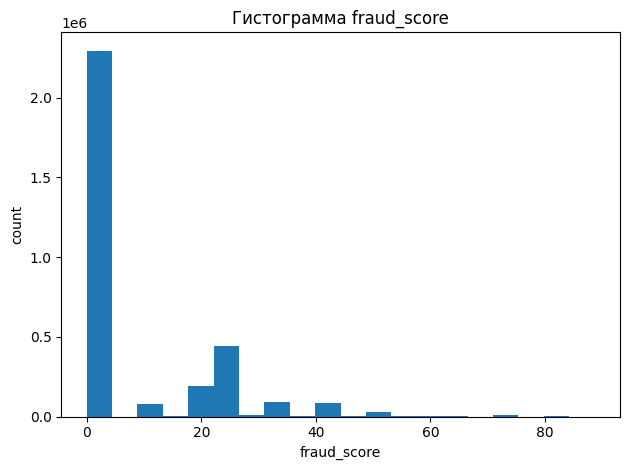

In [137]:
scores = [row['fraud_score'] for row in final_with_flags.select("fraud_score").collect()]

plt.figure()
plt.hist(scores, bins=20)          
plt.xlabel("fraud_score")
plt.ylabel("count")
plt.title("Гистограмма fraud_score")
plt.tight_layout()
plt.show()

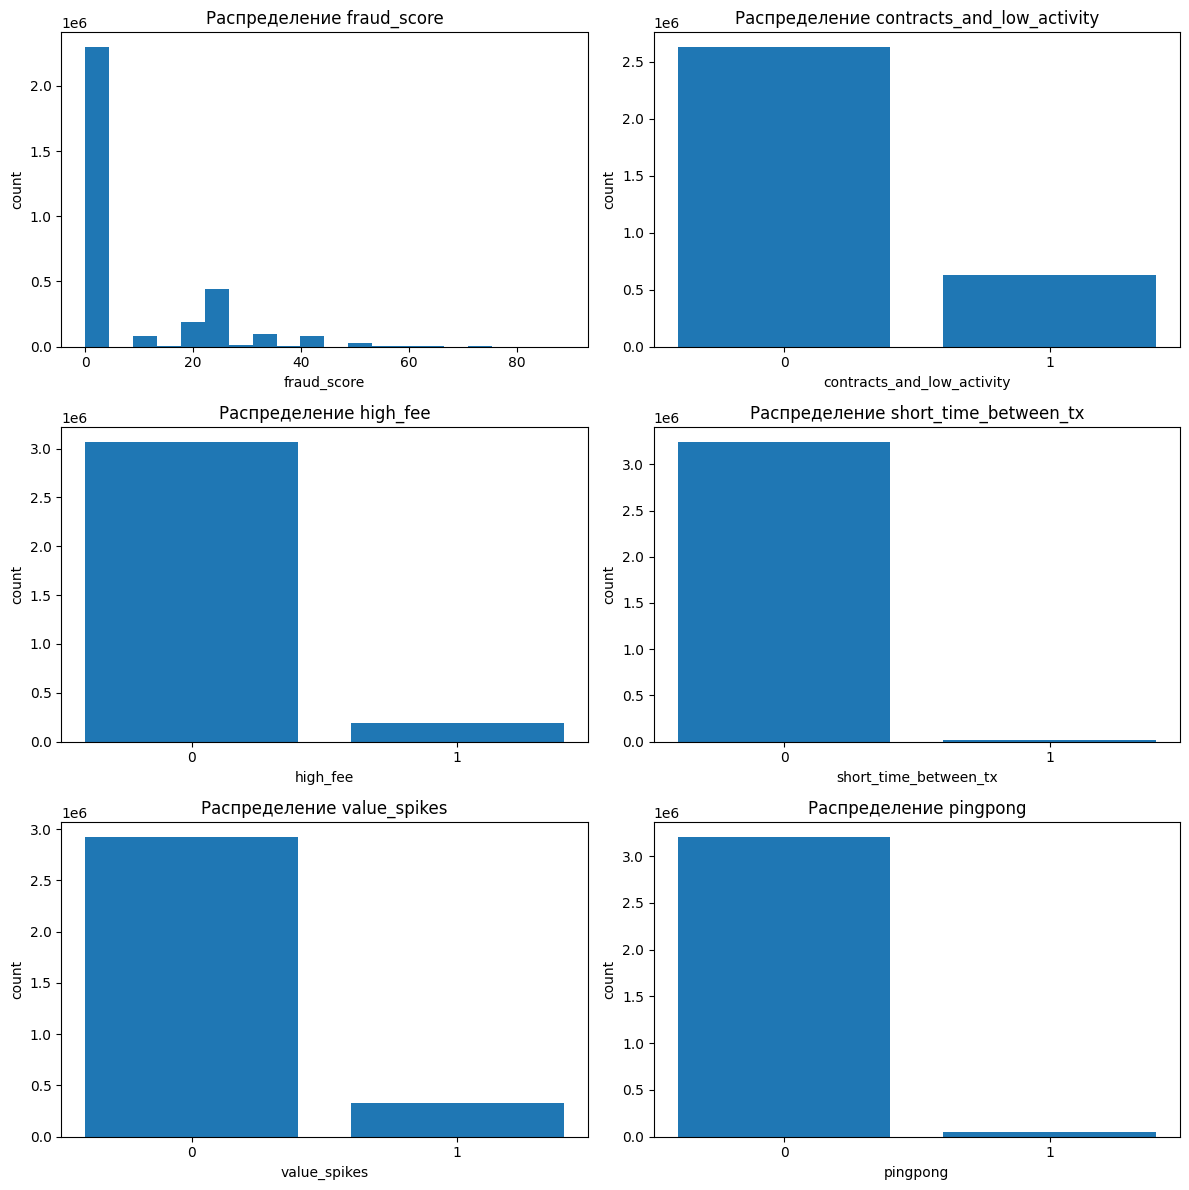

In [139]:
import matplotlib.pyplot as plt

# Список признаков
features = [
    "contracts_and_low_activity",
    "high_fee",
    "short_time_between_tx",
    "value_spikes",
    "pingpong"
]

# Дополнительно можно сделать гистограмму fraud_score как шестой график
# Собираем все scores в список
scores = [row['fraud_score'] for row in final_with_flags.select("fraud_score").collect()]

# Создаём сетку 3×2
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# 1) Гистограмма fraud_score
axes[0].hist(scores, bins=20)
axes[0].set_title("Распределение fraud_score")
axes[0].set_xlabel("fraud_score")
axes[0].set_ylabel("count")

# 2–6) Бар‑графики для каждого бинарного признака
for i, feature in enumerate(features, start=1):
    rows = final_with_flags.groupBy(feature) \
        .count() \
        .orderBy(feature) \
        .collect()
    vals = [str(row[feature]) for row in rows]
    cnts = [row['count'] for row in rows]
    
    axes[i].bar(vals, cnts)
    axes[i].set_title(f"Распределение {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("count")

if len(features) + 1 < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()